In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Prepare a set of grayscale images of handwritten labeled numbers 0, 1, 2, 3, 4, 5, 6, 7, 8, 9 as input for training neural networks. The size of the images is 20 x 20. Make 10 different images of reach number written a little differently.

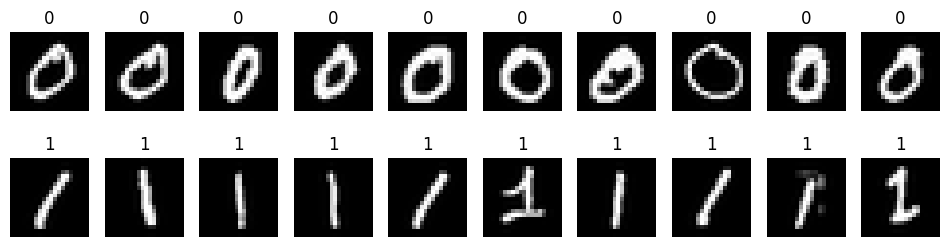

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from PIL import Image

# Load MNIST dataset (28x28 grayscale images)
(x_train, y_train), (_, _) = mnist.load_data()

# Function to resize 28x28 images to 20x20
def resize_image(img):
    pil_img = Image.fromarray(img)                 # Convert NumPy array to PIL image
    pil_img = pil_img.resize((20, 20), Image.LANCZOS)  # Resize to 20x20
    return np.array(pil_img)                       # Convert back to NumPy array

# Apply resizing to the entire training set
x_resized = np.array([resize_image(img) for img in x_train])

# Select the first 10 images for each digit (0–9)
images, labels = [], []
for digit in range(10):
    idx = np.where(y_train == digit)[0][:10]      # Find indices of digit
    images.extend(x_resized[idx])                 # Add images
    labels.extend([digit] * 10)                   # Add corresponding labels

images = np.array(images)
labels = np.array(labels)

# Visualize the first 20 images
fig, axes = plt.subplots(2, 10, figsize=(12, 3))
for i in range(20):
    axes[i // 10, i % 10].imshow(images[i], cmap="gray")
    axes[i // 10, i % 10].set_title(labels[i])
    axes[i // 10, i % 10].axis("off")
plt.show()


Prepare some test images (not labeled) for testing the trained Perceptron.

In [16]:
import os
# import numpy as np
from tensorflow.keras.datasets import mnist
from PIL import Image

# 1. Load MNIST dataset
(_, _), (x_test, y_test) = mnist.load_data()

# 2. Output folder for unlabeled test images
output_dir = "test_digits_20x20"
os.makedirs(output_dir, exist_ok=True)

# 3. Pick 5 random samples for each digit (unlabeled)
np.random.seed(42)  # for reproducibility
for digit in range(10):
    idx = np.where(y_test == digit)[0]
    chosen = np.random.choice(idx, 5, replace=False)  # pick 5
    for i, id_ in enumerate(chosen):
        img = Image.fromarray(x_test[id_])
        img = img.resize((20, 20), Image.LANCZOS)
        img = img.convert("L")  # ensure grayscale
        # Save without label in filename
        img.save(os.path.join(output_dir, f"digit_{digit}_{i}.png"))

print(f"Unlabeled test images saved: {output_dir}")


Unlabeled test images saved: test_digits_20x20


In [18]:
import os
from PIL import Image

output_dir = "digits_20x20"
os.makedirs(output_dir, exist_ok=True)

for i, (img_arr, label) in enumerate(zip(images, labels)):
    digit_dir = os.path.join(output_dir, str(label))
    os.makedirs(digit_dir, exist_ok=True)
    Image.fromarray(img_arr).save(os.path.join(digit_dir, f"{label}_{i}.png"))


In [19]:
import os
import cv2
import numpy as np
from PIL import Image

# Generate synthetic digit images (0–9), each with slight variations
def generate_digits(folder="digits_20x20", img_size=20, variants=10):
    os.makedirs(folder, exist_ok=True)
    font = cv2.FONT_HERSHEY_SIMPLEX
    for digit in range(10):
        digit_dir = os.path.join(folder, str(digit))
        os.makedirs(digit_dir, exist_ok=True)
        for i in range(variants):
            img = np.zeros((img_size, img_size), dtype=np.uint8)
            font_scale = np.random.uniform(0.5, 0.8)
            thickness = np.random.randint(1, 3)
            x = np.random.randint(0, 6)
            y = np.random.randint(12, 20)
            cv2.putText(img, str(digit), (x, y), font, font_scale, (255), thickness, cv2.LINE_AA)
            cv2.imwrite(f"{digit_dir}/{i}.png", img)

# Load grayscale images and flatten them
def load_images(folder, img_size=20):
    X, y = [], []
    for label in range(10):
        digit_folder = os.path.join(folder, str(label))
        for fname in os.listdir(digit_folder):
            path = os.path.join(digit_folder, fname)
            img = Image.open(path).resize((img_size, img_size)).convert("L")
            X.append(np.array(img).flatten() / 255.0)
            y.append(label)
    return np.array(X), np.array(y)

# Convert labels to one-hot vectors
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# Single-layer Perceptron
class Perceptron:
    def __init__(self, input_size, output_size=10):
        self.W = np.random.randn(input_size, output_size) * 0.01
        self.b = np.zeros((1, output_size))

    def forward(self, X):
        self.Z = np.dot(X, self.W) + self.b
        self.A = sigmoid(self.Z)
        return self.A

    def compute_loss(self, y_hat, y):
        m = y.shape[0]
        return -np.sum(y * np.log(y_hat + 1e-8)) / m

    def backprop(self, X, y, y_hat, lr=0.1):
        m = y.shape[0]
        dZ = y_hat - y
        dW = np.dot(X.T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        self.W -= lr * dW
        self.b -= lr * db

    def train(self, X, y, epochs=100, lr=0.1):
        for epoch in range(epochs):
            y_hat = self.forward(X)
            loss = self.compute_loss(y_hat, y)
            self.backprop(X, y, y_hat, lr)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

if __name__ == "__main__":
    generate_digits()
    X_train, y_train = load_images("digits_20x20")
    y_train_oh = one_hot(y_train)

    model = Perceptron(input_size=400, output_size=10)
    model.train(X_train, y_train_oh, epochs=100)

    preds = model.predict(X_train)
    acc = np.mean(preds == y_train)
    print(f"Training Accuracy: {acc:.2%}")


Epoch 0, Loss: 0.6903
Epoch 10, Loss: 1.8719
Epoch 20, Loss: 1.8053
Epoch 30, Loss: 1.6818
Epoch 40, Loss: 1.5748
Epoch 50, Loss: 1.4880
Epoch 60, Loss: 1.4170
Epoch 70, Loss: 1.3575
Epoch 80, Loss: 1.3065
Epoch 90, Loss: 1.2619
Training Accuracy: 72.50%
